# Chapter 2 -- Ultrafast Pulses in Cavities

This notebook explores the the interaction of ultrafast pulses with a Fabry-Perot cavity.  

The goal is to add more physical context and provide a visualization of the math that was introduced during the lecture. 

## Packages, Functions and Variables

The following code-block contains the packages, functions and variables needed for the code found later in this notebook.  It must be run first.  Note that if you are running this on your personal computer, you should ensure that all packages needed are installed first (for example the [numpy](https://numpy.org/), [scipy](https://scipy.org/), and [matplotlib](https://matplotlib.org/) packages must be installed on your computer along with others).  You can find a launcher link at the top to conveniently run this notebook in Google Colab.  

The code below is hidden by default, but you are encouraged to expand it and study it.  The functions and constants will update as needed during the progression of the course, so you should note what new functions have been and added and study how they work.  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets

#--Physical Constants--
hbar = 1.054e-34 #normalized Planck constant [J*s]
evcon = 1.602e-19 #conversion factor, [J/eV]
eta = 119.91699832*np.pi #impedance of freespace [ohms]
me = 9.10938188e-31 #mass of electron [kg]
c = 2.99792458e8 #speed of light [m/s]
e = 1.602e-19 #electron charge [C]

#--Gaussian Pulse Function --
def gaussian_pulse(t, fwhm, wc, phi_ce):
    """
    [E, A] = gaussian_pulse(t, fwhm, wc, phi_ce)

    Function for generating a Gaussian pulse form with given intensity FWHM.
    Outputs electric field profile and intensity envelope, both normalized to
    peak of 1.  Units need to be self-consistent between t, fwhm, and wc.

    Inputs:
    -----------
      t --> time 
      fwhm --> full width at half max of the intensity envelope
      wc --> central frequency (rad/unit time)
      phi_ce --> carrier envelope phase offset (rad)

    Outputs:
    -------------
      pulse['E'] --> Electric field profile (peak of 1)
      pulse['A'] --> Intensity envelope (peak of 1)
    
    """


    #Now determine constant for gaussian envelope from fwhm:
    tau = fwhm/(2*np.sqrt(np.log(2)));

    #Finally, define the pulse:
    E_envelope = np.exp(-t**2/(2*tau**2));
    
    pulse = {}

    pulse['E'] = E_envelope*np.cos(wc*t + phi_ce);

    pulse['A'] = E_envelope**2;
    
    return pulse

## Define and Plot E-Fields from a Pulse

We need to start by defining our pulse and its envelope. We can use the pre-defined function in the headers block above for that.

### Time-Domain Fields

Text(0, 0.5, 'Field/Envelope (Normalized)')

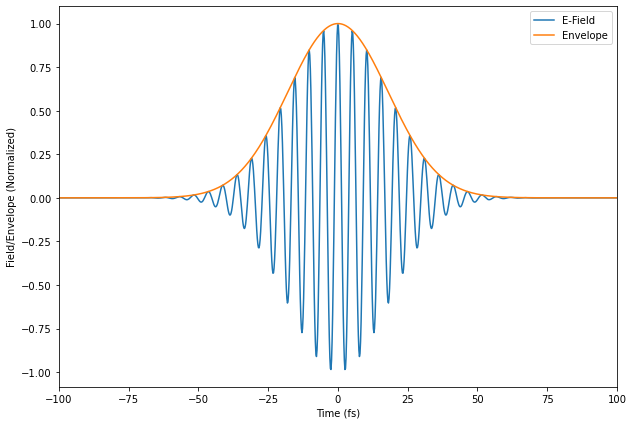

In [6]:
# -- Pulse Settings -- 
yc = 1.55 # central wavelength in micrometers
phi_ce = 0
fwhm = 30 #this one is in femtoseconds


# -- Calculations  -- 
t_ax = np.linspace(-1000, 1000, 10000) #time in fs
wc = 2*np.pi*c*1e-15/(yc*1e-6) # angular frequency in rad/fs
pulse = gaussian_pulse(t_ax, fwhm, wc, phi_ce) #pulse information
A = np.sqrt(pulse['A']) #code provides intensity envelope, we need to convert to field envelope...
E = pulse['E'] #Fields for reference

# -- Plotting -- 
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(t_ax, pulse['E'], label='E-Field')
plt.plot(t_ax, np.sqrt(pulse['A']), label='Envelope')

plt.xlim(-100, 100)
plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Field/Envelope (Normalized)')

### Frequency-Domain Representation

Text(0, 0.5, 'Intensity')

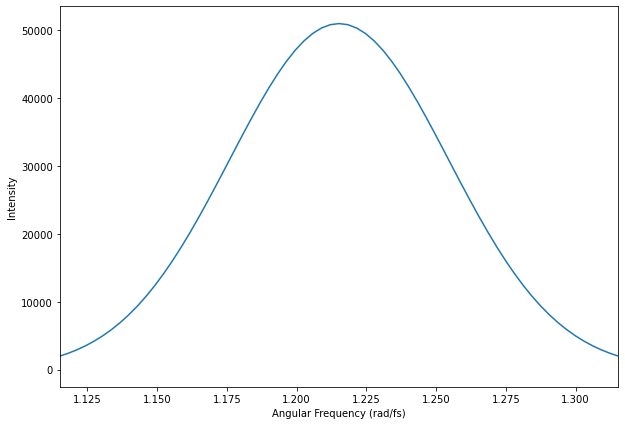

In [3]:
#Take the FT of the envelope
A_f = np.fft.fft(A)

#Define the frequency axis
dt = t_ax[1] - t_ax[0]
w = 2*np.pi*np.fft.fftfreq(pulse['E'].size, dt)

#Plot the result
fig = plt.figure()
fig.set_size_inches(10, 7)

plt.plot(np.fft.fftshift(w + wc), np.fft.fftshift(np.abs(A_f)**2))
plt.xlim(wc - 0.1, wc + 0.1)

plt.xlabel('Angular Frequency (rad/fs)')
plt.ylabel('Intensity')


## Fabry-Perot Cavity

Here we define the transfer function we derived for the Fabry-Perot cavity.  

We explicitly define the phase accumulated between the elements as `phi = k*L`.  This way we can play with the length of the Fabry-Perot cavity and observe the output pulse envelope.  

### $H$ and Cavity Output When Driven by the Pulse

Here we calculate and examine the amplitude and phase of the complex transfer function of the cavity $H$, and the outgoing pulse in frequency and time. 

The code below is slightly more complicated as we use widgets to let us dynamically change parameters.  However, I think this is useful for your own simulations in the future so that you can see how different parameters change the behavior more easily.  

Some questions to think about:
 - How does $L$ control the spacing between the pass-band peaks?  Why?
 - What happens when the spacing $L$ is not an integer number of wavelengths (i.e. $L/\lambda \neq n$)?
 - What is the impact of the power reflectivity R on the pass-band response?  Why?
 - How might the Fabry-Perot cavity be leveraged for dispersion compensation?

In [4]:

# -- Code -- 
#See lecture notes for definitions here...
k = (w + wc)*1e15*1e-6/c #Be careful of units here!


def H_calc(R, L):
    
    T = 1 - R
    phi = -1*k*L

    H = -T*np.exp(1j*phi)*(1 - R*np.exp(-1j*2*phi))/(1 + R**2 - 2*R*np.cos(2*phi))
    
    return H


#We now define the plotting within a function.
#We do this as we are going to use interactive widgets to let us dynamically
#change parameters and replot.  This can be very useful for visualization
#and study.  
def update(R, L):
    
    H = H_calc(R, L)
    
    #Calculate outputs:
    A_out_f = A_f*H
    A_out = np.fft.ifft(A_out_f)
    
    #Update plots
    fig = plt.figure()
    fig.set_size_inches(7.5, 15)
    
    ax = []
    ax.append(fig.add_subplot(4,1,1))
    ax.append(fig.add_subplot(4,1,2))
    ax.append(fig.add_subplot(4,1,3))
    ax.append(fig.add_subplot(4,1,4))
    
    # -- Plot |H|^2 --
    ax[0].plot(np.fft.fftshift(w + wc), np.abs(np.fft.fftshift(H))**2)
    ax[0].set_xlim(wc - 0.1, wc + 0.1)
    ax[0].set_xlabel('Angular Frequency (rad/fs)')
    ax[0].set_ylabel('|H|^2')

    # -- Plot arg(H) --
    ax[1].plot(np.fft.fftshift(w + wc), np.angle(np.fft.fftshift(H)))
    ax[1].set_xlim(wc - 0.1, wc + 0.1)
    ax[1].set_xlabel('Angular Frequency (rad/fs)')
    ax[1].set_ylabel('arg(H) (rad)')

    #-- Plot Frequency Spectrum of Transmitted Pulse -- 
    ax[2].plot(np.fft.fftshift(w + wc), np.abs(np.fft.fftshift(A_out_f))**2)
    ax[2].set_xlim(wc - 0.02, wc + 0.02)
    ax[2].set_xlabel('Angular Frequency (rad/fs)')
    ax[2].set_ylabel('|A_out_f|^2')

    #-- Plot Outgoing Pulse Intensity in Time --
    ax[3].plot(t_ax, np.abs(A_out)**2)
    ax[3].set_xlabel('Time (fs)')
    ax[3].set_ylabel('A_out^2')


    
ipywidgets.interact(update, L=ipywidgets.FloatText(value=10), R=ipywidgets.FloatSlider(min=0.0, max=0.99, value=0.5, step=0.01))

interactive(children=(FloatSlider(value=0.5, description='R', max=0.99, step=0.01), FloatText(value=10.0, desc…

<function __main__.update(R, L)>